# Прогнозирование температуры звезды

Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

-   Закон смещения Вина.
-   Закон Стефана-Больцмана.
-   Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

## **Характеристики**

-   Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
-   Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
-   Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
-   Звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа.
-   Тип звезды:
    -   Коричневый карлик: 0
    -   Красный карлик: 1
    -   Белый карлик: 2
    -   Звёзды главной последовательности: 3
    -   Сверхгигант: 4
    -   Гипергигант: 5

-   Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.
    
В этом самостоятельном проекте вам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

💡 Справочная информация: Светимость Солнца (англ. _Average Luminosity of Sun_) $L0$ =3.828⋅1026ВтL0​=3.828⋅1026Вт Радиус Солнца (англ. _Average Radius of Sun_) $R0$ =6.9551⋅108мR0​=6.9551⋅108м


**Цель работы** - разработать нейронную сеть для предсказания абсолютной температуры на поверхности звезды на основе характеристик звезд, таких как относительная светимость, относительный радиус, абсолютная звездная величина, звездный цвет и тип звезды.

**Основные этапы работы:**
1.  Загрузка и ознакомление с данными;
2.  Обработка и анализ данных;
3.  Препроцессинг выборок;
4.  Построение базовой нейронной сети;
5.  Улучшение нейронной сети;
6.  Выводы.

# Библиотеки, установки и функции

In [49]:
import os

import warnings

import time

import re

import random


import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder


import torch
import torch.nn as nn
import torch.optim as optim


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Константы и установки

In [50]:
DATA_PATH1 = "./6_class.csv"
DATA_PATH2 = "./datasets/6_class.csv"


RANDOM_STATE = 42
TEST_SIZE = 0.2

SCALER = MinMaxScaler()
OHE = OneHotEncoder(drop="first")


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)


pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

sns.set_theme(style="whitegrid")

warnings.filterwarnings("ignore")

## Функции

### Работа с данными

In [51]:
def df_quik_view(df, asc=False):
    '''
    This function provides a quick overview of the input DataFrame by
    returning a summary table containing information such as number of
    unique values, missing values, data type, completeness percentage, and
    unique values of each column in the DataFrame. It also prints general 
    information such as the shape of the table, the number and percentage of
    duplicates in the table, and the memory usage of the table.
    
    Parameters:
    df (pd.DataFrame): a pandas DataFrame to analyze.
    asc (bool): a boolean value indicating whether to sort unique values in
                ascending order. Default is False, which means descending order.
    
    Returns:
    pd.DataFrame: a summary table of the input DataFrame containing the number
                  of unique values, missing values, data type, completeness
                  percentage, and unique values of each column.
    '''
    unique_values = []
    for i in df.columns:
        unique_values.append(df[i].sort_values(ascending=asc).unique())

    table_scan = pd.DataFrame(
        {
            'values_num': df.count(),
            'nulls_num': df.isna().sum(),
            'completeness': 100 - (df.isna().sum() / (df.isna().sum() + 
                                                      df.notna().sum()) * 100),
            'uniques_num': df.nunique(),
            'unique_values': unique_values,
            'dtype': df.dtypes
        }
    )

    memory = df.memory_usage(index=False).sum() / 1_000_000

    print('General data analysis:')
    print()
    print('Shape of the table:     ', df.shape)
    print('Duplicates in the table: {}, ({}%)'
          .format(df.duplicated().sum(),
                  round(df.duplicated().sum() / df.shape[0], 4) * 100)
         )
    print('Memory usage:            ' + str(round(memory, 1)) + '+ MB')
    print()
    return table_scan

In [52]:
def change_dtypes(data, **dtypes):
    '''
    This function changes the data types of the specified columns in a pandas
    DataFrame and returns the updated DataFrame.
        
    Parameters:
    data (pd.DataFrame): a pandas DataFrame to modify.
    **dtypes (dict): keyword arguments representing the column names and
    new data types to apply to the columns.
        
    Returns:
    pd.DataFrame: a pandas DataFrame with updated data types for the
    specified columns.
    '''
    memory_before = data.memory_usage(index=False).sum()
    print(f'Initial value of memory usage:                 ', memory_before)

    data = data.astype(dtypes)

    memory_after = data.memory_usage(index=False).sum()
    memory_percent = round(
        (memory_before - memory_after) / memory_before * 100,2)

    print('Value of memory usage after changing data types:', memory_after)
    print()
    print(f'Memory usage reduced by {memory_percent}%', '\n')

    return data

In [53]:
def group_colors(ds):
    colors = {
        "reds": [],
        "oranges": [],
        "blues": [],
        "whites": [],
        "yellows": [],
        "others": [],
    }

    for color in ds["color"].unique():
        if "red" in color:
            colors["reds"].append(color)
        elif "orange" in color:
            colors["oranges"].append(color)
        elif "blue" in color:
            colors["blues"].append(color)
        elif "white" in color:
            colors["whites"].append(color)
        elif "yellow" in color:
            colors["yellows"].append(color)
        else:
            colors["others"].append(color)

    print("RED: \n", colors["reds"], "\n")
    print("ORANGE: \n", colors["oranges"], "\n")
    print("BLUE: \n", colors["blues"], "\n")
    print("WHITE: \n", colors["whites"], "\n")
    print("YELLOW: \n", colors["yellows"], "\n")
    if len(colors["others"]) > 0:
        print()
        print("-------------------------")
        print("UNMATCHED COLORS:")
        print(colors["others"])

    return colors

In [96]:
def remove_outs(data, feature):
    data = data[feature]

    i = data.quantile(q=0.75) - data.quantile(q=0.25)

    w1 = data.quantile(q=0.25) - 1.5 * (i)
    w2 = data.quantile(q=0.75) + 1.5 * (i)

    data = data.where(data > w1, None)
    data = data.where(data < w2, None)
    
    return data

### Визуализация

In [55]:
def create_visualization(data, dtype, target, is_cat_target=False,
                         figsize=None, bins=50):
    '''
    This function creates visualizations for scalar and categorical
    features and the target variable. It uses the seaborn and matplotlib
    libraries for plotting.

    Parameters:
    data (pandas.DataFrame): The dataset to be visualized.
    dtype (str): Type of visualization to be created. 'scalars' for quantitative
                 features, 'categories' for categorical features and target
                 variable prevalence, 'target' for target variable distribution.
    target (str): The name of the target variable.
    is_cat_target (bool, optional): If True, the target variable is categorical.
                                    Default is False.
    figsize (tuple, optional): Figure size. Default is None.
    bins (int, optional): Number of bins for histograms. Default is 50.

    Returns:
    None.
    '''
    sns.set_theme(style="white")
    if dtype == 'scalars':
        target_nunique = data[target].nunique()

        print('Visualization of quantitative features distribution:')
        print()

        if is_cat_target:
            for i in data.drop(target, axis=1):
                if data[i].dtype != 'O' and data[i].unique().shape[0] > 10:
                    print(f'Feature: {i}')

                    figure, (ax_box, ax_hist) = plt.subplots(
                        2, 1, sharex=True,
                        gridspec_kw={'height_ratios': (.3, .7)},
                        figsize=(9, 7) if figsize is None else figsize)

                    sns.despine(fig=None, ax=None, top=True, right=True,
                                left=False, bottom=False, offset=None,
                                trim=False)

                    sns.boxplot(data=data, x=i, y=target, orient='h',
                                ax=ax_box).set_title(i, y=1.5, fontsize=14)
                    sns.histplot(data=data, x=i, hue=target, kde=True, 
                                 bins=bins).set_ylabel('Amount')

                    plt.show()
                    print()
                    print('Feature statistics:')
                    display(pd.DataFrame(data[i].describe()).apply(round,
                                                                   args=[2]))
        else:
            for i in data.drop(target, axis=1):
                if data[i].dtype != 'O' and not is_cat_target:
                    print(f'Feature: {i}')

                    figure, (ax_box, ax_hist) = plt.subplots(
                        2, 1, sharex=True,
                        gridspec_kw={'height_ratios': (.3, .7)},
                        figsize=(9, 7) if figsize is None else figsize)

                    sns.despine(fig=None, ax=None, top=True, right=True,
                                left=False, bottom=False, offset=None,
                                trim=False)

                    sns.boxplot(data=data, x=i, ax=ax_box).set_title(
                        i, y=1.5, fontsize=14)
                    sns.histplot(data=data, x=i, kde=True, bins=bins
                                 ).set_ylabel('Amount')

                    plt.show()
                    print()
                    print('Feature statistics:')
                    display(pd.DataFrame(data[i].describe()).apply(round,
                                                                   args=[2]))
    elif dtype == 'categories':
        sns.set_theme(style="whitegrid")
        print('Visualization of categorical features and target prevalence:')
        print()

        for i in data.drop(target, axis=1):
            if data[i].dtype == 'O' or is_cat_target:
                bar_data = data[i].value_counts().reset_index().rename(
                    columns={'index': data[i].name, data[i].name: 'Count'}
                    ).sort_values(by=i)

                if is_cat_target:
                    prev_data = (data.groupby([i])[target]
                                 .value_counts(normalize=True)
                                 .reset_index(name='prevalance'))
                    prev_data['prevalance'] = (
                        prev_data['prevalance'].round(4) * 100)
                else:
                    prev_data = (data.groupby([i])[target]
                                 .mean()
                                 .reset_index(name='target_mean'))
                    prev_data['target_mean'] = prev_data['target_mean'].round(2)

                print(f'Feature: {i}')

                figure, (ax_bar, ax_prev) = plt.subplots(
                    1, 2, figsize=(18, 5) if figsize is None else figsize)

                sns.barplot(data=bar_data, x=i, y='Count',
                            linewidth=0.5, ax=ax_bar,
                            color='#CC8963', alpha=0.8).set_title(
                                f'{i} distribution', y=1.02, fontsize=14)
                if is_cat_target:
                    try:
                        sns.barplot(data=prev_data, x=i, y='prevalance',
                                    hue=target, linewidth=0.5,
                                    palette={0: '#008744', 1: '#d62d20'},
                                    ax=ax_prev, alpha=0.8).set_title(
                                        f'target prevalence, %', y=1.02,
                                        fontsize=14)
                    except:
                        sns.barplot(data=prev_data, x=i, y='prevalance',
                                    hue=target, ax=ax_prev, alpha=0.8
                                    ).set_title(f'target prevalence, %', y=1.02,
                                                fontsize=14)
                else:
                    sns.barplot(data=prev_data, x=i, y='target_mean',
                                color='#008744', alpha=0.8).set_title(
                                    f'target means', y=1.02, fontsize=14)

                r_ = 0 if bar_data.shape[0] < 5 else 90
                ax_bar.tick_params(axis='x', rotation=r_)
                ax_prev.tick_params(axis='x', rotation=r_)

                plt.show()
                print()
    elif dtype == 'target':
        print('Visualization of target distribution:')
        print()
        print(f'Target: {target}')

        if is_cat_target:
            plt.figure(figsize=(5, 5) if figsize is None else figsize)

            target_ = data[target].value_counts().reset_index().rename(
                columns={'index': data[target].name,
                         data[target].name: 'Amount'})

            sns.barplot(
                data=target_,
                x=target, y='Amount'
            ).set_title(f"Target {target} categories", y=1.02, fontsize=14)

            plt.show()
            print()
            print('Target statistics:')
            display(pd.DataFrame(data[target].describe()))
        else:
            print('Visualization of target distribution:')
            print()
            print(f'Target: {target}')

            figure, (ax_box, ax_hist) = plt.subplots(
                2, 1, sharex=True, gridspec_kw={'height_ratios': (.25, .75)},
                figsize=(9, 7) if figsize is None else figsize)

            sns.despine(fig=None, ax=None, top=True, right=True, left=False,
                        bottom=False, offset=None, trim=False)

            sns.boxplot(data=data,
                        x=target, ax=ax_box
            ).set_title(f"Target {target} distribution", y=1.5, fontsize=14)
            sns.histplot(data=data, x=target, kde=True, bins=bins)

            plt.show()
            print()
            print('Feature statistics:')
            display(pd.DataFrame(data[target].describe()))

    print()

In [56]:
def visualize_feature_for_target_classes(ds, feature, target, target_class):
    '''
    This function generates a visualization of a specific feature for a target class in a dataset.

    Parameters:
    ds (pandas.DataFrame): The input dataset.
    feature (str): The feature for which to generate a visualization.
    target (str): The name of the target column in the dataset.
    target_class (str): The target class for which to generate the visualization.

    Returns:
    None
    '''
    print(f"---------- {feature.title()} statistics for target class {target_class} ----------")
    print()
    create_visualization(data=ds[ds[target] == target_class][[feature, target]],
                         dtype="scalars", target="type", is_cat_target=True,
                         figsize=(9, 6))

In [57]:
def get_corr_map(df, method="pearson", figisze=(15, 12)):
    '''
    This function takes a pandas DataFrame and generates a correlation matrix
    using the specified correlation method. The resulting matrix is plotted as
    a heatmap using seaborn library.

    Parameters:
    df (pandas.DataFrame): The input dataframe
    method (str), default="pearson": The correlation method to be used.
                                     The options are 'pearson', 'kendall',
                                     or 'spearman'.
    figisze (tuple): default=(15, 12) The figure size of the resulting plot.
    
    Returns:
    None
    '''
    plt.figure(figsize=figisze)
    sns.heatmap(
        round(df.corr(method=method), 2), vmax=1, vmin=-1, square=True,
        linewidths=3, annot=True, cmap='coolwarm'
    )
    plt.show()

In [58]:
def check_preds(df):
    '''
    This function takes a pandas DataFrame and generates a line plot to compare
    the actual and predicted values for a target variable.
    The function is useful for visually assessing the quality of a
    predictive model's performance.

    Parameters:
    df (pandas.DataFrame): The input dataframe

    Returns:
    None
    '''
    df = pd.DataFrame({
        'Star number': range(len(df)),
        'Actual': df['real_target'],
        'Predicted': df['predicted_target']
    })

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df.index, y='Actual', data=df, color="#008744")
    sns.lineplot(x=df.index, y='Predicted', data=df, color="#d62d20")
    
    plt.xlabel('Star number')
    plt.ylabel('Temperature, K')
    plt.title('Fact - Prediction')
    plt.legend(labels=['Real', 'Predicted'])
    plt.show()

### Замер времени

In [59]:
def exec_time(start, end):
    '''
    This function calculates the difference between two given datetime objects
    and returns the difference in the format of HH:MM:SS.

    Parameters
    start: datetime object
    end: datetime object
    Returns
    diff_time (str): The difference between the two given datetime objects in
                     the format of HH:MM:SS.
    '''
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))

    return "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)

### ML

In [60]:
def train_model(model, X_train, y_train, butch_size=2, epochs_mul=10):
    import torch.optim as optim
    import torch.nn.functional as F

    num_epochs = X_train.size()[0] * epochs_mul
    print("Number of iterations:", num_epochs)
    print("Size of butches:     ", butch_size)
    print()

    print("Start training...")
    start_time = time.time()
    model.fit(
        X_train, y_train, num_epochs=num_epochs, batch_size=butch_size)
    stop_type = time.time()
    print("Training completed")
    print("Studying time:", exec_time(start_time, stop_type))

    return model

# Загрузка данных и первичная обработка

## Загрузка данных

In [97]:
if os.path.exists(DATA_PATH1):
    data = pd.read_csv(DATA_PATH1)
elif os.path.exists(DATA_PATH2):
    data = pd.read_csv(DATA_PATH2)
else:
    raise Exception("Path doesn't exist!")

data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,"0,0024","0,17","16,12",0,Red
1,1,3042,"0,0005","0,1542","16,6",0,Red
2,2,2600,"0,0003","0,102","18,7",0,Red
3,3,2800,"0,0002","0,16","16,65",0,Red
4,4,1939,"0,000138","0,103","20,06",0,Red


## Ознакомление с данными и приведение в рабочий вид

In [98]:
df_quik_view(data)

General data analysis:

Shape of the table:      (240, 7)
Duplicates in the table: 0, (0.0%)
Memory usage:            0.0+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
Unnamed: 0,240,0,100.0,240,"[239, 238, 237, 236, 235, 234, 233, 232, 231, ...",int64
Temperature (K),240,0,100.0,228,"[40000, 39000, 38940, 38234, 37882, 37800, 361...",int64
Luminosity(L/Lo),240,0,100.0,208,"[998, 9,25, 883, 849420, 834042, 813000, 8,7, ...",object
Radius(R/Ro),240,0,100.0,216,"[98, 97, 955, 92, 89, 88, 876, 86, 84, 83, 81,...",object
Absolute magnitude(Mv),240,0,100.0,228,"[6,506, 6,228, 5,49, 5,05, 5,03, 4,78, 4,68, 4...",object
Star type,240,0,100.0,6,"[5, 4, 3, 2, 1, 0]",int64
Star color,240,0,100.0,17,"[yellowish, yellow-white, white, Yellowish Whi...",object


При первичном ознакомлении и высокоуровневом анализе данных можно выделить следующие моменты, требующие обработки:

1. Имена полей пишутся с использованием пробелов, заглавных букв и небуквенных символов, что может затруднять дальнейшую работу;
2. Используемые типы данных требуют чрезмерного объема памяти для своих значений;
3. Количественные признаки указаны в виде строки и с использованием запятой вместо плавующей точки.

Решим данные моменты.

### Приведение названий полей к единому стилю

In [99]:
data = data.drop('Unnamed: 0', axis=1)
data = data.rename(
    columns={
        "Temperature (K)":          "temperature",
        "Luminosity(L/Lo)":         "luminosity",
        "Radius(R/Ro)":             "radius",
        "Absolute magnitude(Mv)":   "magnitude",
        "Star type":                "type",
        "Star color":               "color"
    }
)

print('Сolumn names after processing:')
data.columns

Сolumn names after processing:


Index(['temperature', 'luminosity', 'radius', 'magnitude', 'type', 'color'], dtype='object')

### Оптимизация использования памяти и обработка количественных полей

In [100]:
data["luminosity"] = data["luminosity"].str.replace(",", ".").apply(float)
data["radius"] = data["radius"].str.replace(",", ".").apply(float)
data["magnitude"] = data["magnitude"].str.replace(",", ".").apply(float)

dtypes = {
    "temperature":      "int32",
    "luminosity":       "float32",
    "radius":           "float16",
    "magnitude":        "float16",
    "type":             "int8"
}

data = change_dtypes(data, **dtypes)
df_quik_view(data)

Initial value of memory usage:                  11520
Value of memory usage after changing data types: 5040

Memory usage reduced by 56.25% 

General data analysis:

Shape of the table:      (240, 6)
Duplicates in the table: 0, (0.0%)
Memory usage:            0.0+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
temperature,240,0,100.0,228,"[40000, 39000, 38940, 38234, 37882, 37800, 361...",int32
luminosity,240,0,100.0,208,"[849420.0, 834042.0, 813000.0, 783930.0, 74889...",float32
radius,240,0,100.0,216,"[1948.0, 1783.0, 1779.0, 1679.0, 1673.0, 1648....",float16
magnitude,240,0,100.0,226,"[20.06, 20.02, 19.94, 19.62, 19.56, 19.45, 19....",float16
type,240,0,100.0,6,"[5, 4, 3, 2, 1, 0]",int8
color,240,0,100.0,17,"[yellowish, yellow-white, white, Yellowish Whi...",object


# Предобработка и анализ данных

## Целевой признак - `temperature`

Visualization of target distribution:

Target: temperature
Visualization of target distribution:

Target: temperature


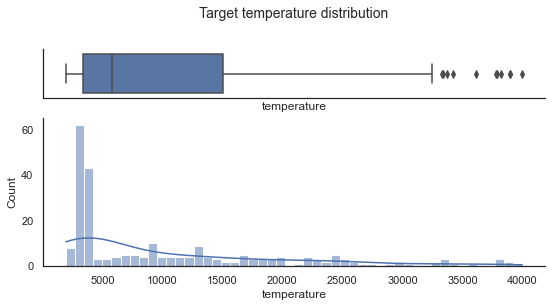


Feature statistics:


,temperature
count,240.000000
mean,10497.462500
std,9552.425037
min,1939.000000
25%,3344.250000
50%,5776.000000
75%,15055.500000
max,40000.000000


In [101]:
create_visualization(data=data, dtype="target", target="temperature",
                     is_cat_target=False, figsize=(9, 4))

Целевой признак представлен неравномерным распределением с наличием выбросов, что в совокупности с крайне малым количеством данных может осложнить построение модели.

Учтем данный фактор, а также разобъем целевой признак поквантильно на 4 категории для удобства анализа дальнейших параметров.

In [102]:
data["temperature_cats"] = pd.qcut(data["temperature"], 4)
data["temperature_cats"].unique()

[(1938.999, 3344.25], (3344.25, 5776.0], (15055.5, 40000.0], (5776.0, 15055.5]]
Categories (4, interval[float64, right]): [(1938.999, 3344.25] < (3344.25, 5776.0] < (5776.0, 15055.5] < (15055.5, 40000.0]]

## luminosity

Visualization of quantitative features distribution:

Feature: luminosity


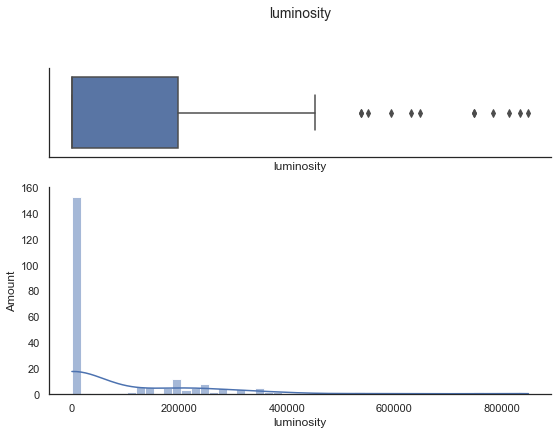


Feature statistics:


,luminosity
count,240.00
mean,107188.37
std,179432.19
min,0.00
25%,0.00
50%,0.07
75%,198050.00
max,849420.00


In [103]:
create_visualization(data=data[["luminosity", "temperature"]], dtype="scalars",
                     target="temperature", is_cat_target=False, figsize=(9, 6))

Данные представлены очень неравномерно - присутствует как преимещество нулевых значений, так и выбросы.

Visualization of quantitative features distribution:

Feature: luminosity


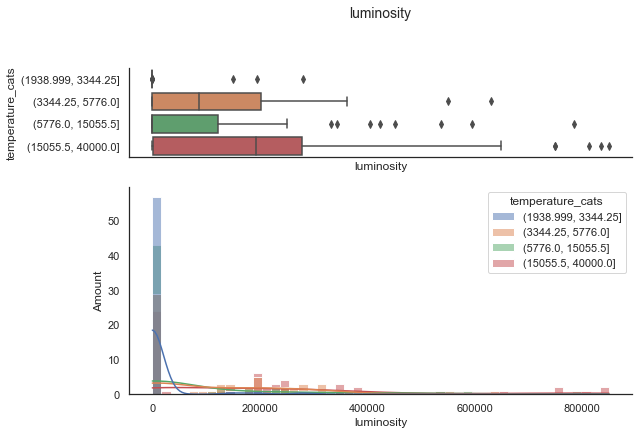


Feature statistics:


,luminosity
count,240.00
mean,107188.37
std,179432.19
min,0.00
25%,0.00
50%,0.07
75%,198050.00
max,849420.00


In [104]:
create_visualization(data=data[["luminosity", "temperature_cats"]], dtype="scalars",
                     target="temperature_cats", is_cat_target=True, figsize=(9, 6))

Можно увидеть, что для разных категорий целевого признака у параметра присутствуют свои средние значения с прямой связью: чем больше данный параметр, тем выше температура звезды.

Visualization of categorical features and target prevalence:

Feature: is_luminosity


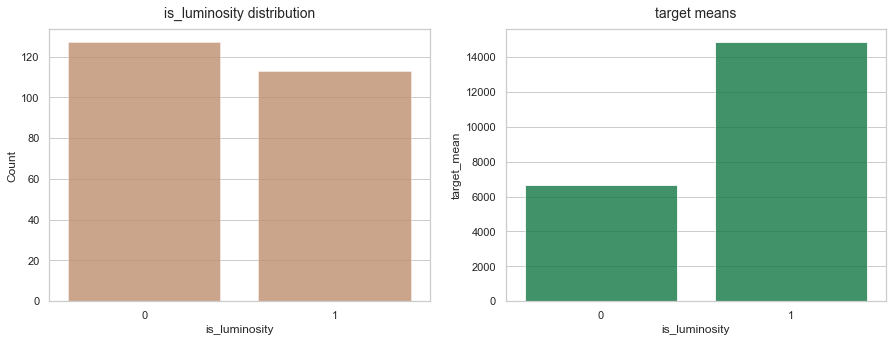

In [105]:
data["is_luminosity"] = data["luminosity"].apply(
    lambda x: 1 if x > 1 else 0).astype("object")

create_visualization(data=data[["is_luminosity", "temperature"]], dtype="categories",
                     target="temperature", is_cat_target=False, figsize=(15, 5))

Выявленная взаимосвязь отлично прослеживается и при привидении параметра к бинарному виду. Учтем этот факт при построении датасета.

## radius

Visualization of quantitative features distribution:

Feature: radius


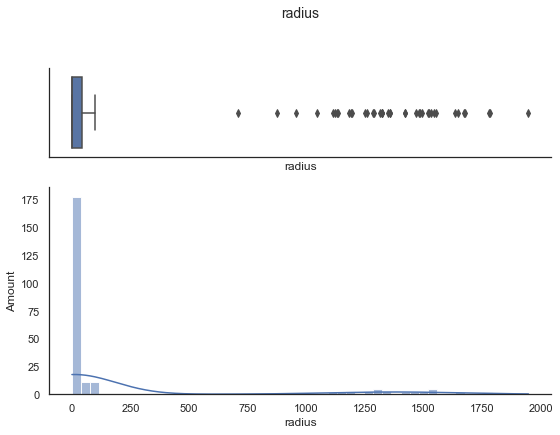


Feature statistics:


,radius
count,240.00
mean,237.25
std,inf
min,0.01
25%,0.10
50%,0.76
75%,42.75
max,1948.00


In [106]:
create_visualization(data=data[["radius", "temperature"]], dtype="scalars",
                     target="temperature", is_cat_target=False, figsize=(9, 6))

Данные представлены очень неравномерно - присутствует как преимещество нулевых значений, так и выбросы.

Visualization of quantitative features distribution:

Feature: radius


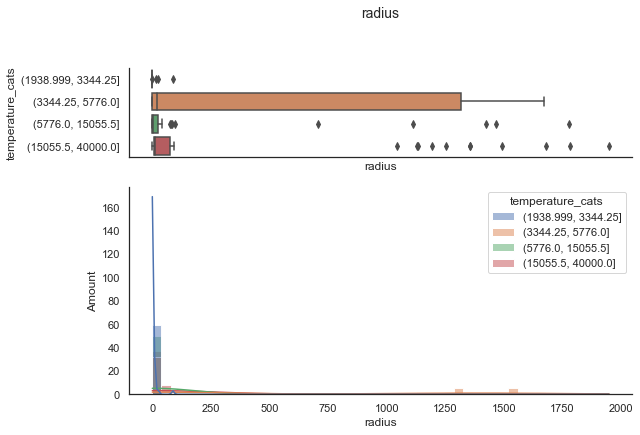


Feature statistics:


,radius
count,240.00
mean,237.25
std,inf
min,0.01
25%,0.10
50%,0.76
75%,42.75
max,1948.00


In [107]:
create_visualization(data=data[["radius", "temperature_cats"]], dtype="scalars",
                     target="temperature_cats", is_cat_target=True, figsize=(9, 6))

Можно увидеть, что значение целевого признака от радиуса не является явным, хотя и прослеживается небольшая прямая зависимость.

Visualization of categorical features and target prevalence:

Feature: is_big_radius


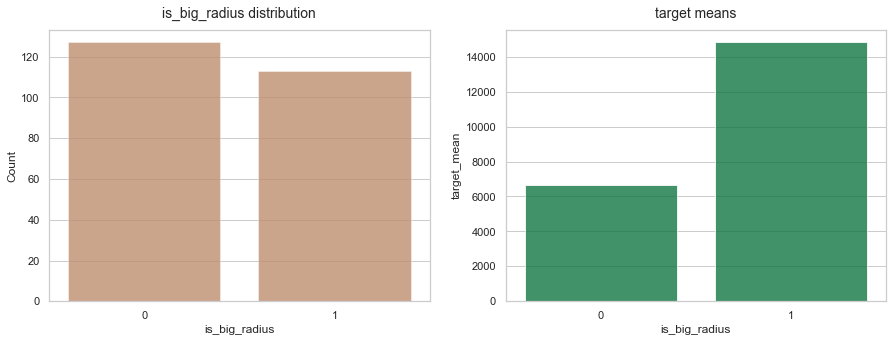

In [108]:
data["is_big_radius"] = data["radius"].apply(
    lambda x: 1 if x > 1 else 0).astype("object")

create_visualization(data=data[["is_big_radius", "temperature"]], dtype="categories",
                     target="temperature", is_cat_target=False, figsize=(15, 5))

Тем не менее, при приведении параметра к бинарному виду, данная прямая связь становиться более отчетливой.

Вероятно, при построении датасета будет приоритетней придать бинарную форму для данного признака.

## magnitude

Visualization of quantitative features distribution:

Feature: magnitude


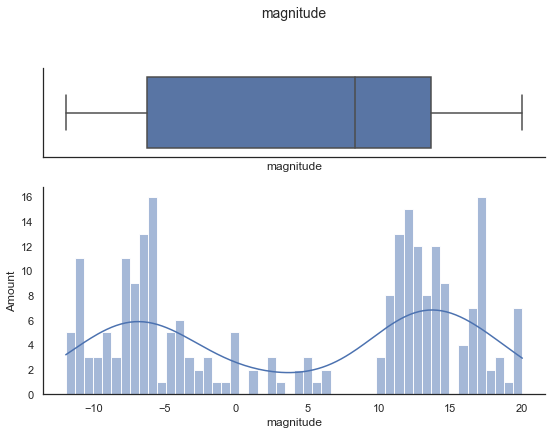


Feature statistics:


,magnitude
count,240.00
mean,4.38
std,10.53
min,-11.92
25%,-6.23
50%,8.31
75%,13.70
max,20.06


In [109]:
create_visualization(data=data[["magnitude", "temperature"]], dtype="scalars",
                     target="temperature", is_cat_target=False, figsize=(9, 6))

Visualization of quantitative features distribution:

Feature: magnitude


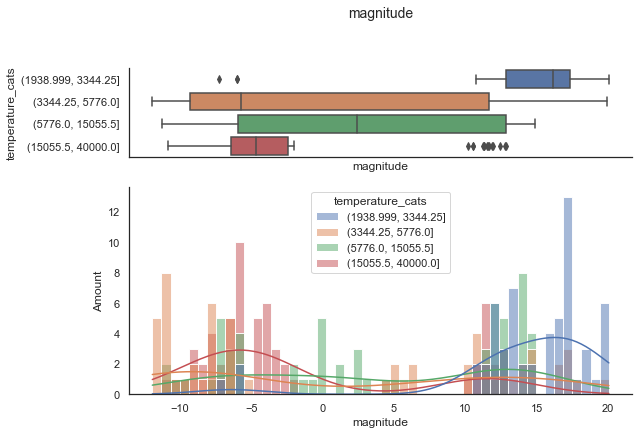


Feature statistics:


,magnitude
count,240.00
mean,4.38
std,10.53
min,-11.92
25%,-6.23
50%,8.31
75%,13.70
max,20.06


In [110]:
create_visualization(data=data[["magnitude", "temperature_cats"]], dtype="scalars",
                     target="temperature_cats", is_cat_target=True, figsize=(9, 6))

Данные магнитуды умещаются в межквартильный размах и демонстрируют отсутсвие выбросов, а также сильные различия в средних значения для разных категорий целевого признака.

## color

Visualization of categorical features and target prevalence:

Feature: color


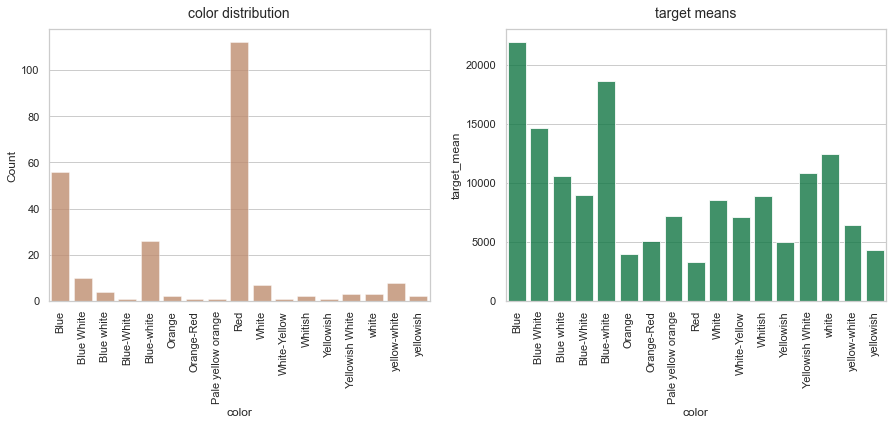

In [111]:
create_visualization(data=data[["color", "temperature"]], dtype="categories",
                     target="temperature", is_cat_target=False, figsize=(15, 5))

Цвет звезды однозначно сильно влияет на её температуру, однако в данных обнаружены следующие ошибки и аномалии:
1. Названия цветов пересекаются или одни и теже названия цветов записаны с ошибками
2. Некоторые категории цветов крайне слабо представлены, что обуславливает их объединение в общие группы или исключение из датасета.

Рассмотрим данный параметр подробнее и обработаем его.

### Анализ параметра в разрезе категорий

Visualization of categorical features and target prevalence:

Feature: color


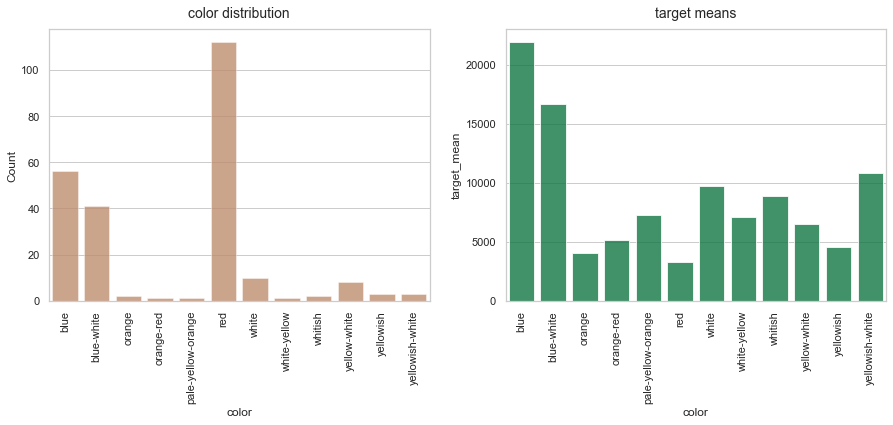

In [112]:
data["color"] = data["color"].apply(lambda x: x.lower().replace(" ", '-'))

create_visualization(data=data[["color", "temperature"]], dtype="categories",
                     target="temperature", is_cat_target=False, figsize=(15, 5))

Сформируем основные группы цветов.

In [113]:
colors = group_colors(data)

RED: 
 ['red', 'orange-red'] 

ORANGE: 
 ['pale-yellow-orange', 'orange'] 

BLUE: 
 ['blue-white', 'blue'] 

WHITE: 
 ['white', 'yellowish-white', 'yellow-white', 'white-yellow'] 

YELLOW: 
 ['yellowish'] 


-------------------------
UNMATCHED COLORS:
['whitish']


In [114]:
colors

{'reds': ['red', 'orange-red'],
 'oranges': ['pale-yellow-orange', 'orange'],
 'blues': ['blue-white', 'blue'],
 'whites': ['white', 'yellowish-white', 'yellow-white', 'white-yellow'],
 'yellows': ['yellowish'],
 'others': ['whitish']}

In [115]:
colors_stat = data["color"].value_counts(normalize=True)
colors_stat

red                   0.466667
blue                  0.233333
blue-white            0.170833
white                 0.041667
yellow-white          0.033333
yellowish-white       0.012500
yellowish             0.012500
whitish               0.008333
orange                0.008333
pale-yellow-orange    0.004167
white-yellow          0.004167
orange-red            0.004167
Name: color, dtype: float64

#### Красные цвета

Visualization of categorical features and target prevalence:

Feature: color


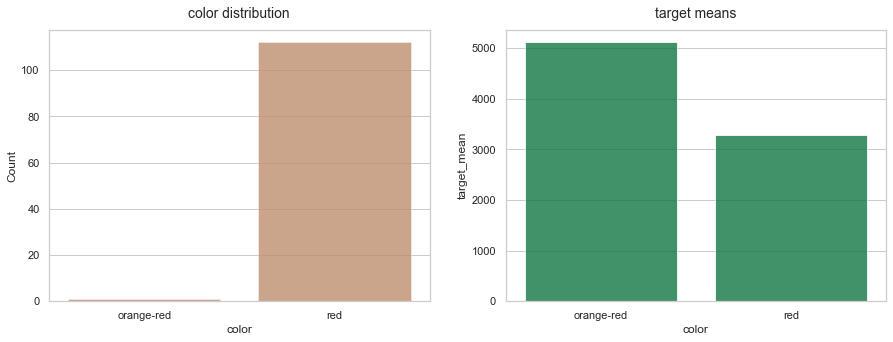

In [116]:
create_visualization(
    data=data[data["color"].isin(colors["reds"])][["color", "temperature"]],
    dtype="categories", target="temperature", is_cat_target=False,
    figsize=(15, 5))

#### Оранжевые цвета

Visualization of categorical features and target prevalence:

Feature: color


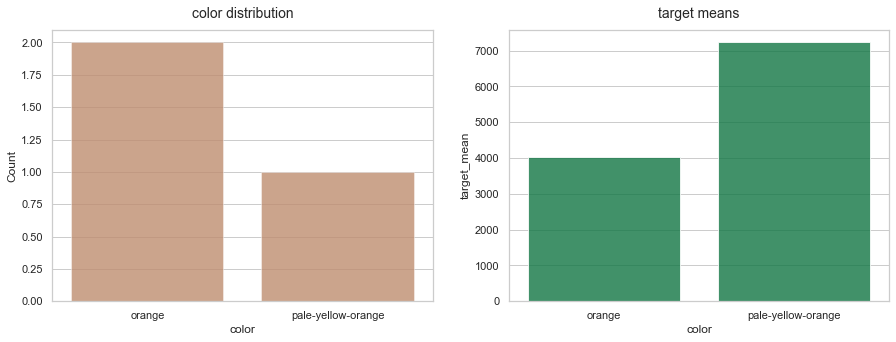

In [117]:
create_visualization(
    data=data[data["color"].isin(colors["oranges"])][["color", "temperature"]],
    dtype="categories", target="temperature", is_cat_target=False,
    figsize=(15, 5))

#### Синие цвета

Visualization of categorical features and target prevalence:

Feature: color


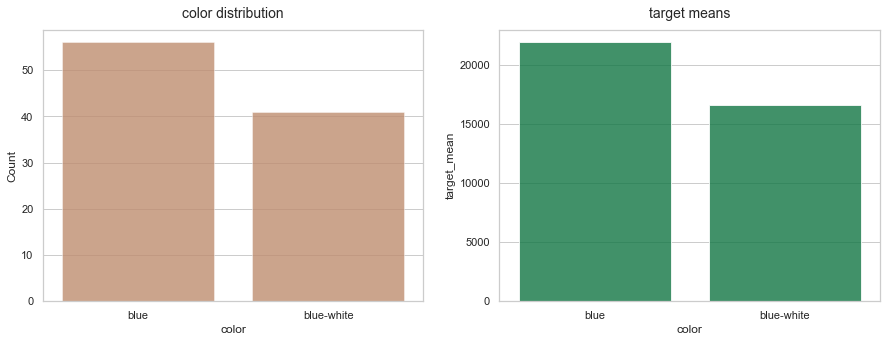

In [118]:
create_visualization(
    data=data[data["color"].isin(colors["blues"])][["color", "temperature"]],
    dtype="categories", target="temperature", is_cat_target=False,
    figsize=(15, 5))

#### Белые цвета

Visualization of categorical features and target prevalence:

Feature: color


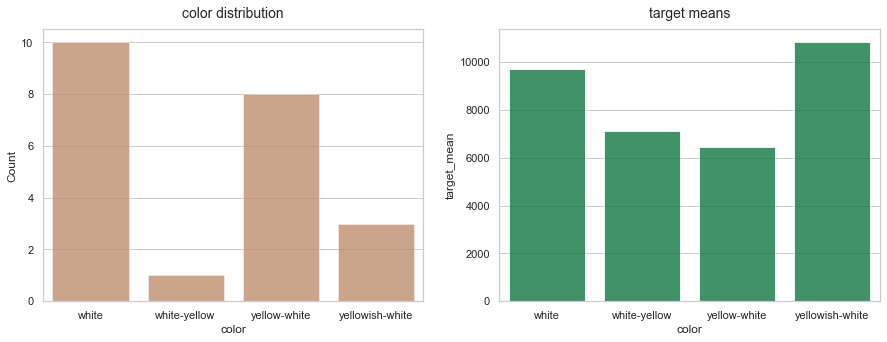

In [119]:
create_visualization(
    data=data[data["color"].isin(colors["whites"])][["color", "temperature"]],
    dtype="categories", target="temperature", is_cat_target=False,
    figsize=(15, 5))

#### Желтые цвета

Visualization of categorical features and target prevalence:

Feature: color


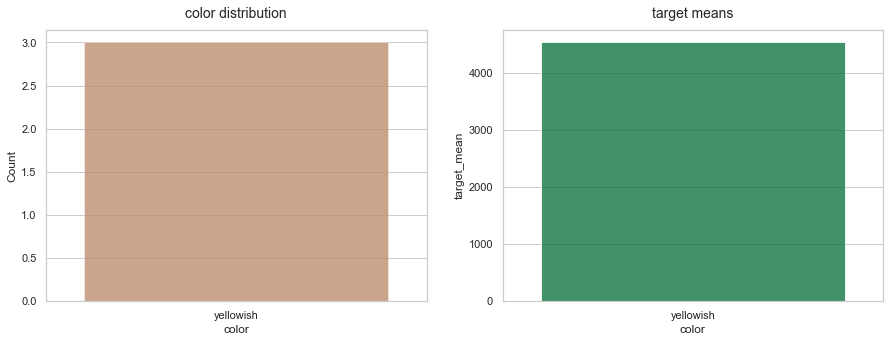

In [120]:
create_visualization(
    data=data[data["color"].isin(colors["yellows"])][["color", "temperature"]],
    dtype="categories", target="temperature", is_cat_target=False,
    figsize=(15, 5))

#### Прочие цвета

Visualization of categorical features and target prevalence:

Feature: color


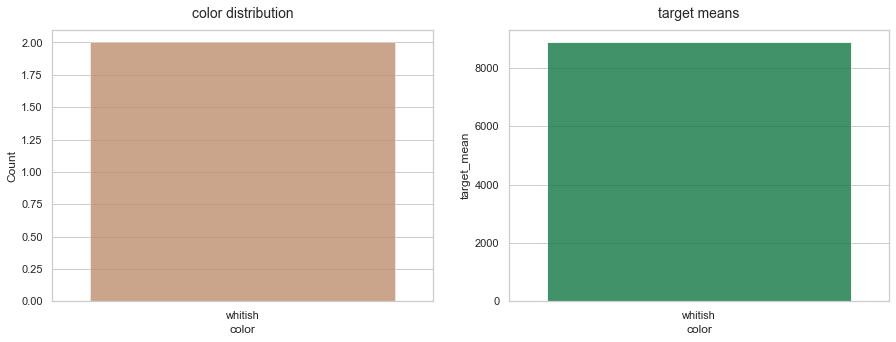

In [121]:
create_visualization(
    data=data[data["color"].isin(colors["others"])][["color", "temperature"]],
    dtype="categories", target="temperature", is_cat_target=False,
    figsize=(15, 5))

### Обработка цветов

Проделанный анализ, позволяет сделать вывод, что ввиду слабой представленности некоторых групп цветов, параметр стоит переработать, объединив данные в самые представленные категории.

In [122]:
main_colors = list(colors_stat[colors_stat > 0.05].index)
main_colors

['red', 'blue', 'blue-white']

Visualization of categorical features and target prevalence:

Feature: color


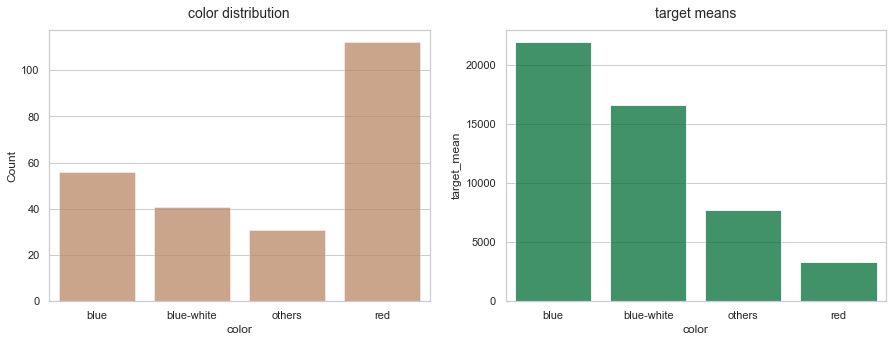

In [123]:
data["color"] = data["color"].apply(
    lambda x: x if x in main_colors else "others")

create_visualization(data=data[["color", "temperature"]], dtype="categories",
                     target="temperature", is_cat_target=False, figsize=(15, 5))

## Корреляционный анализ

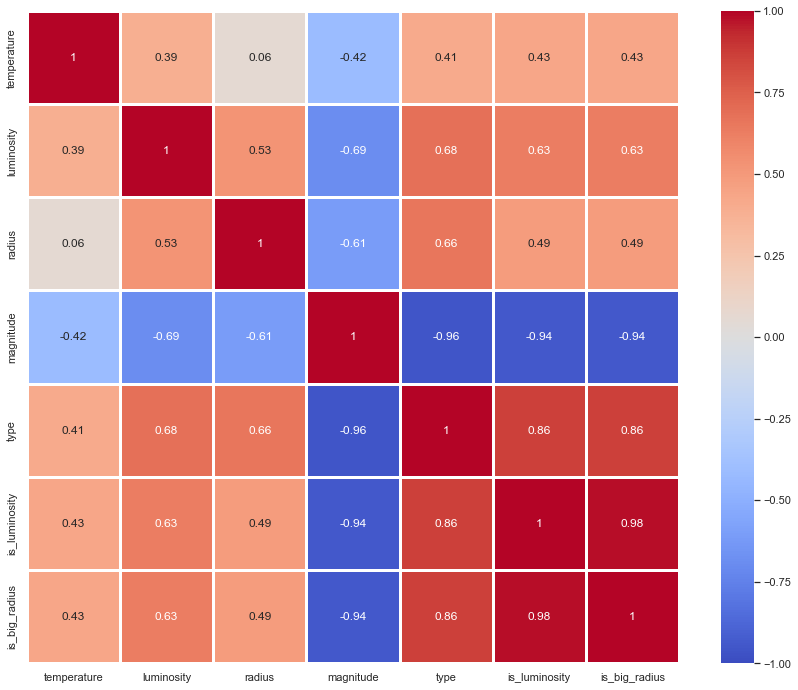

In [124]:
data["is_luminosity"] = data["is_luminosity"].astype("int8")
data["is_big_radius"] = data["is_big_radius"].astype("int8")

get_corr_map(data)

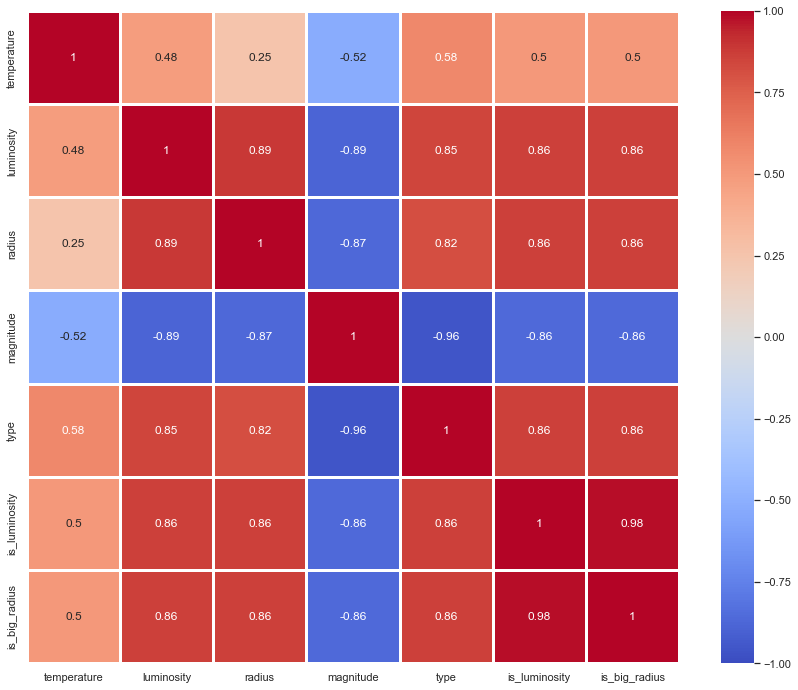

In [125]:
get_corr_map(data, "spearman")

## Сборка датасета

In [129]:
data["temperature"] = remove_outs(data, "temperature")
data["radius"] = remove_outs(data, "radius")
data["luminosity"] = remove_outs(data, "luminosity")


ds = pd.DataFrame(
    {
        # Categorical features
        "c_color":          data["color"],
        "c_type":           data["type"].astype("object"),

        # Quantitative features
        "q_luminosity":     data["luminosity"],#.apply(lambda x: 0 if x < 1 else x),
        # "q_radius":         data["radius"],#.apply(lambda x: 0 if x < 1 else x),
        "q_magnitude":      data["magnitude"],

        # Binary features
        "b_big_radius":     data["is_big_radius"],

        # Target
        "target":           data["temperature"]
    }
).reset_index(drop=True)

print("Dataset assembled.")
print()

print("Nulls values in data was dropped:           ", ds.isna().sum().sum())
ds = ds.dropna().reset_index(drop=True)

print()
print("Duplicates in data:                         ", ds.duplicated().sum())
ds = ds.drop_duplicates().reset_index(drop=True)
print("Duplicates in data after processing:        ", ds.duplicated().sum())
print()

cat_features = []
for i in ds.columns:
    if not pd.isna(re.search("^c.*", i)):
        cat_features.append(i)

q_features = list(ds.drop(cat_features, axis=1).columns)[0:-1]

print("DS shape:                                   ", ds.shape)
print("The amount of observations has decreased by:",
      f"{100 - round(ds.shape[0] / data.shape[0] * 100, 2)}%")
print()
print("Cat features:")
print(cat_features)
print()
print("Quantitative features:")
print(q_features)
print()
print("Dataset sample:")
ds.head()

Dataset assembled.

Nulls values in data was dropped:            33

Duplicates in data:                          0
Duplicates in data after processing:         0

DS shape:                                    (211, 6)
The amount of observations has decreased by: 12.079999999999998%

Cat features:
['c_color', 'c_type']

Quantitative features:
['q_luminosity', 'q_magnitude', 'b_big_radius']

Dataset sample:


,c_color,c_type,q_luminosity,q_magnitude,b_big_radius,target
0,red,0,0.002400,16.125000,0,3068.0
1,red,0,0.000500,16.593750,0,3042.0
2,red,0,0.000300,18.703125,0,2600.0
3,red,0,0.000200,16.656250,0,2800.0
4,red,0,0.000138,20.062500,0,1939.0


In [130]:
df_quik_view(ds)

General data analysis:

Shape of the table:      (211, 6)
Duplicates in the table: 0, (0.0%)
Memory usage:            0.0+ MB



,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
c_color,211,0,100.0,4,"[red, others, blue-white, blue]",object
c_type,211,0,100.0,6,"[5, 4, 3, 2, 1, 0]",object
q_luminosity,211,0,100.0,181,"[382993.0, 363000.0, 347820.0, 342940.0, 34290...",float32
q_magnitude,211,0,100.0,198,"[20.06, 20.02, 19.94, 19.62, 19.56, 19.45, 19....",float16
b_big_radius,211,0,100.0,2,"[1, 0]",int8
target,211,0,100.0,199,"[26373.0, 26140.0, 26000.0, 25390.0, 25070.0, ...",float64


## Формирование выборок

In [131]:
X = ds.drop("target", axis=1)
y = ds["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print("Sampling was successful!")
print("\n")
print("The shape of the training set for features: ",
      X_train.shape)
print("The shape of the training set for target:   ",
      y_train.shape)
print()
print("The shape of the test set for features:     ",
      X_test.shape)
print("The shape of the test set for target:       ",
      y_test.shape)

Sampling was successful!


The shape of the training set for features:  (168, 5)
The shape of the training set for target:    (168,)

The shape of the test set for features:      (43, 5)
The shape of the test set for target:        (43,)


### Номрализация выборок

In [132]:
scaler = SCALER.fit(X_train[q_features])

X_train[q_features] = scaler.transform(X_train[q_features])
X_test[q_features] = scaler.transform(X_test[q_features])

print("Train sample:")
display(X_train.sample(3))
print()
print("Test sample:")
display(X_test.sample(3))

Train sample:


,c_color,c_type,q_luminosity,q_magnitude,b_big_radius
130,red,1,8.668566e-09,0.755007,0.0
22,others,2,2.349912e-10,0.817538,0.0
17,red,1,9.373539e-09,0.710308,0.0



Test sample:


,c_color,c_type,q_luminosity,q_magnitude,b_big_radius
104,red,5,5.222027e-01,0.018564,1.0
195,blue,2,3.054886e-09,0.735955,0.0
135,blue-white,2,1.932150e-09,0.745481,0.0


### OHE

In [133]:
ohe = OHE.fit(X_train[cat_features])

X_train_ohe = ohe.transform(X_train[cat_features]).toarray()
X_test_ohe = ohe.transform(X_test[cat_features]).toarray()

X_train = np.concatenate([X_train_ohe, X_train[q_features]], axis=1)
X_test = np.concatenate([X_test_ohe, X_test[q_features]], axis=1)

print('Train shape:     ', X_train.shape)
print()
print('Validation shape:', X_test.shape)

Train shape:      (168, 11)

Validation shape: (43, 11)


### Перевод данных в формат тензеров

In [134]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train.values)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test.values)

print("Train sample tensor:")
print(X_train[:3, :])
print(y_train[:3])
print()
print("Test sample tensor:")
print(X_test[:3, :])
print(y_test[:3])

Train sample tensor:
tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 5.7965e-09, 8.3390e-01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 7.3631e-01, 1.6610e-02, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 2.2768e-08, 7.4597e-01, 0.0000e+00]])
tensor([3243., 4015., 3150.])

Test sample tensor:
tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 2.9661e-03, 3.1116e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.2298e-09, 8.9399e-01, 0.0000e+00],
        [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.5666e-10, 8.3586e-01, 0.0000e+00]])
tensor([15276.,  348

## Построение базовой нейронной сети

In [135]:
class BaselineNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3,
                 out_size, learning_rate=0.01):
        super(BaselineNet, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        nn.init.normal_(self.fc1.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.1)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.1)

        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.1)

        self.fc4 = nn.Linear(hidden_size3, out_size)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.1)
        nn.init.normal_(self.fc3.bias, mean=0, std=0.1)

        
        self.leaky_relu = nn.LeakyReLU()


        self.learning_rate = learning_rate
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.leaky_relu(out)

        out = self.fc2(out)
        out = self.leaky_relu(out)

        out = self.fc3(out)
        out = self.leaky_relu(out)

        out = self.fc4(out)

        return out
    
    def fit(self, X_train, y_train, num_epochs=10, batch_size=None,
            verbose=True, plot=True):
        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=batch_size,
                                                shuffle=True)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        total_step = len(train_loader)
        loss_list = []
        for epoch in range(num_epochs):
            if batch_size is not None:
                for i, (inputs, labels) in enumerate(train_loader):
                    inputs = inputs.reshape(-1, self.fc1.in_features)

                    outputs = self(inputs)
                    loss = criterion(outputs, labels)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    if verbose:
                        print ("Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}"
                            .format(epoch+1, num_epochs, i+1, total_step,
                                    np.sqrt(loss.item())))
            else:
                inputs = X_train.reshape(-1, self.fc1.in_features)
                outputs = self(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if verbose:
                    print("Epoch [{}/{}], Loss: {:.4f}"
                          .format(epoch+1, num_epochs, np.sqrt(loss.item())))
            loss_list.append(np.sqrt(loss.item()))
        if plot:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.plot(loss_list, label='RMSE')
            ax.legend()
            ax.set_xlabel('Iteration')
            ax.set_ylabel('RMSE')
            plt.show()

    def predict(self, X):
        with torch.no_grad():
            output = self.forward(X)
            return output

In [156]:
print("Baseline model initialization")
print()

input_size = X_train.size()[1]
hidden_size1 = int(np.ceil(((input_size * 5) ** 0.5)))
hidden_size2 = int(np.ceil((hidden_size1 * 1) ** 0.5))
hidden_size3 = int(np.ceil((hidden_size1 * 0.5) ** 0.5))
out_size = 1


print("Input neurons: ", input_size)
print("Hidden neurons in 1 Layer:", hidden_size1)
print("Hidden neurons in 2 Layer:", hidden_size2)
print("Hidden neurons in 3 Layer:", hidden_size3)
print("Out neurons:   ", out_size)

baseline_model = BaselineNet(input_size, hidden_size1, hidden_size2,
                             hidden_size3, out_size)
print("Model initialized.")
print("Model's parameters:")
print(baseline_model.state_dict())

Baseline model initialization

Input neurons:  11
Hidden neurons in 1 Layer: 8
Hidden neurons in 2 Layer: 3
Hidden neurons in 3 Layer: 2
Out neurons:    1
Model initialized.
Model's parameters:
OrderedDict([('fc1.weight', tensor([[-0.0484,  0.0430, -0.0570, -0.0685,  0.0129,  0.0407, -0.0197,  0.0833,
         -0.0052,  0.1233,  0.0585],
        [-0.2031,  0.0569,  0.1606, -0.0531, -0.0460,  0.0223,  0.0350, -0.0056,
          0.0839,  0.0555, -0.0051],
        [-0.1291, -0.0348, -0.0999, -0.0309,  0.0262,  0.0635,  0.0795,  0.0006,
         -0.0359, -0.2304, -0.1015],
        [ 0.0902, -0.0901,  0.0723, -0.0734, -0.0219, -0.0646, -0.1028, -0.0742,
         -0.0117, -0.0372, -0.1275],
        [-0.0367, -0.0893, -0.1810,  0.1941,  0.1699,  0.0374,  0.1112, -0.0540,
         -0.1111, -0.0274,  0.0546],
        [ 0.1803,  0.0716,  0.0119,  0.0542, -0.1082,  0.0169,  0.0924, -0.0243,
          0.0186,  0.0842,  0.1502],
        [-0.1065, -0.0059,  0.0028,  0.1665,  0.0575, -0.0324,  0.0508

Number of iterations: 3360
Size of butches:      168

Start training...
Epoch [1/3360], Iteration [1/1], Loss: 10750.2673
Epoch [2/3360], Iteration [1/1], Loss: 10750.2532
Epoch [3/3360], Iteration [1/1], Loss: 10750.2383
Epoch [4/3360], Iteration [1/1], Loss: 10750.2234
Epoch [5/3360], Iteration [1/1], Loss: 10750.2082
Epoch [6/3360], Iteration [1/1], Loss: 10750.1926
Epoch [7/3360], Iteration [1/1], Loss: 10750.1766
Epoch [8/3360], Iteration [1/1], Loss: 10750.1598
Epoch [9/3360], Iteration [1/1], Loss: 10750.1438
Epoch [10/3360], Iteration [1/1], Loss: 10750.1271
Epoch [11/3360], Iteration [1/1], Loss: 10750.1088
Epoch [12/3360], Iteration [1/1], Loss: 10750.0895
Epoch [13/3360], Iteration [1/1], Loss: 10750.0690
Epoch [14/3360], Iteration [1/1], Loss: 10750.0486
Epoch [15/3360], Iteration [1/1], Loss: 10750.0270
Epoch [16/3360], Iteration [1/1], Loss: 10750.0032
Epoch [17/3360], Iteration [1/1], Loss: 10749.9779
Epoch [18/3360], Iteration [1/1], Loss: 10749.9522
Epoch [19/3360], It

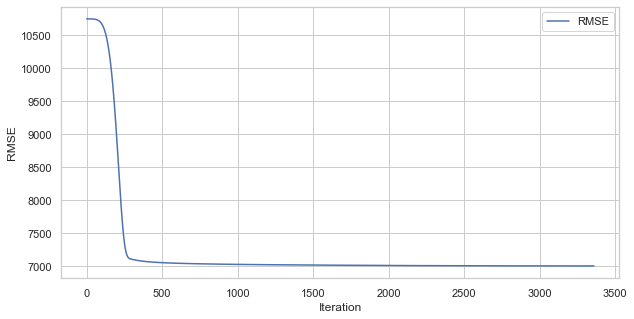

Training completed
Studying time: 00:00:13


In [157]:
baseline_model = train_model(
    baseline_model, X_train, y_train, int(X_train.size()[0]), 20)

In [158]:
preds = baseline_model.predict(X_test)
baseline_val_ds = pd.DataFrame(
    {
        "real_target":          y_test,
        "predicted_target":     preds.numpy()[:, 0],
        "error":                y_test - preds.numpy()[:, 0]
    }
)
baseline_val_ds

,real_target,predicted_target,error
0,15276.0,8103.833008,7172.166992
1,3484.0,8007.453125,-4523.453125
2,7723.0,8262.222656,-539.222656
3,3158.0,8380.877930,-5222.877930
4,2935.0,8291.929688,-5356.929688
5,18734.0,7891.496582,10842.503906
6,3574.0,8514.477539,-4940.477539
7,3496.0,8504.084961,-5008.084961
8,2700.0,7927.318359,-5227.318359
9,12893.0,8015.106445,4877.893555


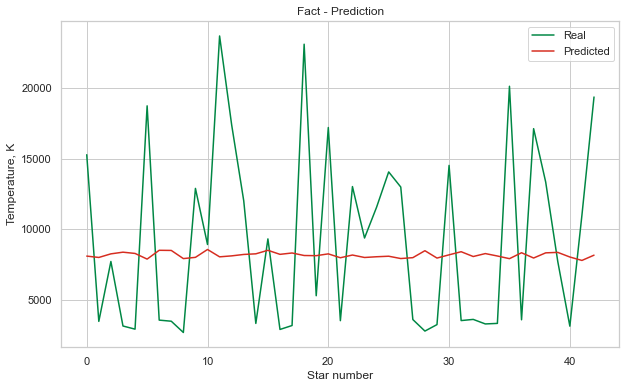

RMSE: 6550.425940349222
R2  : -0.04879232527500932


In [159]:
check_preds(baseline_val_ds)
print("RMSE:", mean_squared_error(y_test, preds)**0.5)
print("R2  :", r2_score(y_test, preds))

Можно сделать вывод, что модель не справляется с прогнозированием реальных значений целевой переменной, о чем сведетельствует высокое значение RMSE и околонулевое значение R2 - по сути модель демонстрирует немногим более худший результат, чем если мы бы использовали среднее значение.

Модель нуждается в дополнительной настройке или пересмотре параметров для повышения точности предсказаний.

## Улучшение нейронной сети

In [167]:
class ImprovedNet(BaselineNet):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, out_size, dropout_prob=0.5):
        super(ImprovedNet, self).__init__(input_size, hidden_size1, hidden_size2, hidden_size3, out_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.bn1 = nn.BatchNorm1d(hidden_size1 * 2)
        self.bn2 = nn.BatchNorm1d(hidden_size2 * 2)
        self.bn3 = nn.BatchNorm1d(hidden_size3 * 2)

    def forward(self, x):
        out = self.leaky_relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)

        out = self.leaky_relu(self.bn2(self.fc2(out)))
        out = self.dropout(out)

        out = self.leaky_relu(self.bn3(self.fc3(out)))
        out = self.dropout(out)

        out = self.fc4(out)
        
        return out

In [168]:
print("Imporoved model initialization")
print()
print("Input neurons: ", input_size)
print("Hidden neurons in 1 Layer:", hidden_size1)
print("Hidden neurons in 2 Layer:", hidden_size2)
print("Hidden neurons in 3 Layer:", hidden_size3)
print("Out neurons:   ", out_size)

improved_model = ImprovedNet(input_size, hidden_size1, hidden_size2, hidden_size3, out_size)
print("Model initialized.")
print("Model's parameters:")
print(improved_model.state_dict())

Imporoved model initialization

Input neurons:  11
Hidden neurons in 1 Layer: 8
Hidden neurons in 2 Layer: 3
Hidden neurons in 3 Layer: 2
Out neurons:    1
Model initialized.
Model's parameters:
OrderedDict([('fc1.weight', tensor([[ 0.1540, -0.1556, -0.0929,  0.0022,  0.1269, -0.0509, -0.2049,  0.0773,
          0.0538, -0.0598,  0.0506],
        [-0.0334, -0.0048, -0.0311,  0.0611,  0.1832,  0.2165,  0.1111, -0.0779,
         -0.1785, -0.0456,  0.0462],
        [ 0.0191, -0.0516,  0.1714,  0.0015,  0.1083, -0.2104, -0.1407, -0.0188,
         -0.0497,  0.2124,  0.1085],
        [ 0.0908,  0.1157,  0.0706,  0.0448,  0.0063, -0.0913, -0.0843,  0.0049,
         -0.0297,  0.0392,  0.0612],
        [ 0.0770,  0.0198,  0.0820,  0.1117, -0.1093,  0.0241, -0.0003, -0.1335,
         -0.0246,  0.0326, -0.1437],
        [ 0.0372,  0.0401,  0.0085,  0.1317, -0.0083, -0.0745, -0.0579,  0.0766,
         -0.0518, -0.0609,  0.0152],
        [ 0.0451, -0.1111,  0.0151, -0.2350,  0.0830, -0.1326, -0.114

Number of iterations: 3360
Size of butches:      168

Start training...
Epoch [1/3360], Iteration [1/1], Loss: 7000.7360
Epoch [2/3360], Iteration [1/1], Loss: 7001.0419
Epoch [3/3360], Iteration [1/1], Loss: 7000.7554
Epoch [4/3360], Iteration [1/1], Loss: 7000.8020
Epoch [5/3360], Iteration [1/1], Loss: 7000.9119
Epoch [6/3360], Iteration [1/1], Loss: 7000.8662
Epoch [7/3360], Iteration [1/1], Loss: 7000.7711
Epoch [8/3360], Iteration [1/1], Loss: 7000.7365
Epoch [9/3360], Iteration [1/1], Loss: 7000.7757
Epoch [10/3360], Iteration [1/1], Loss: 7000.8205
Epoch [11/3360], Iteration [1/1], Loss: 7000.8154
Epoch [12/3360], Iteration [1/1], Loss: 7000.7745
Epoch [13/3360], Iteration [1/1], Loss: 7000.7402
Epoch [14/3360], Iteration [1/1], Loss: 7000.7405
Epoch [15/3360], Iteration [1/1], Loss: 7000.7651
Epoch [16/3360], Iteration [1/1], Loss: 7000.7825
Epoch [17/3360], Iteration [1/1], Loss: 7000.7754
Epoch [18/3360], Iteration [1/1], Loss: 7000.7525
Epoch [19/3360], Iteration [1/1], Los

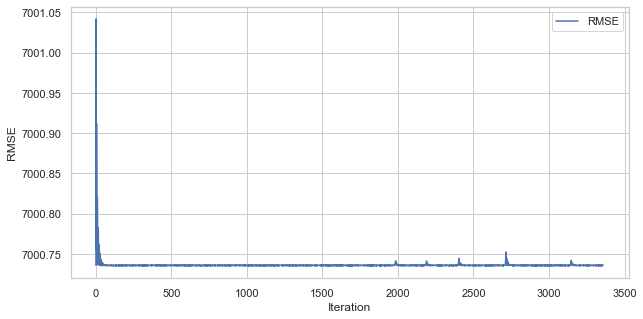

Training completed
Studying time: 00:00:13


In [169]:
improved_model = train_model(baseline_model, X_train, y_train, int(X_train.size()[0]), 20)

In [170]:
preds = improved_model.predict(X_test)
improved_val_ds = pd.DataFrame(
    {
        "real_target":          y_test,
        "predicted_target":     preds.numpy()[:, 0],
        "error":                y_test - preds.numpy()[:, 0]
    }
)
improved_val_ds

,real_target,predicted_target,error
0,15276.0,8162.065918,7113.934082
1,3484.0,8161.561523,-4677.561523
2,7723.0,8161.896973,-438.896973
3,3158.0,8161.888184,-5003.888184
4,2935.0,8161.587402,-5226.587402
5,18734.0,8161.857422,10572.142578
6,3574.0,8162.215820,-4588.215820
7,3496.0,8161.900879,-4665.900879
8,2700.0,8161.554199,-5461.554199
9,12893.0,8161.831543,4731.168457


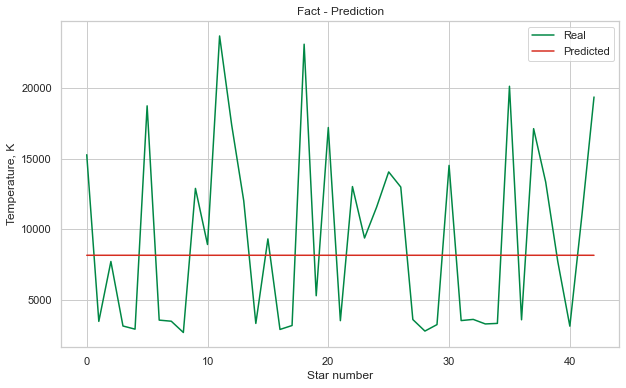

RMSE: 6490.252383382329
R2  : -0.029612006516740008


In [171]:
check_preds(improved_val_ds)
print("RMSE:", mean_squared_error(preds, y_test)**0.5)
print("R2  :", r2_score(y_test, preds))

Можно увидеть, что нейросеть с дроп-аутами и батч-нормализацией лишь незначительно смогла улучшить результат, но так и не смогла преодолеть целевую планку метрики RMSE.

## Выводы

In [148]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(pd.DataFrame(X_train), pd.DataFrame(y_train), verbose=False)

preds = model.predict(pd.DataFrame(X_test))
print("RMSE:", mean_squared_error(preds, pd.DataFrame(y_test))**0.5)

RMSE: 3245.197324990138
